# Solve Maze using Reinforcements Learning

 Explore Reinforcement Learning (RL) basic algorithmsusing mazes of different sizes as our playground to get understanding of the strength of RL algorithms.

# Installs

In [ ]:
%%capture
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install gym
!pip install pygame
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install -U --no-cache-dir gdown --pre
!gdown --id 1FeuIx5OVLmfCx0dxxwU-7Xn8gpPc-53D
!unzip /content/maze_mid.zip

# Imports

In [ ]:
import numpy as np
import gym
from gym import logger as gymlogger
from gym.utils import seeding
from gym import error, spaces, utils
gymlogger.set_level(40) # error only
import glob
import io
import base64
import os
import random
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
from pyvirtualdisplay import Display
from IPython.display import HTML
from IPython import display as ipythondisplay
import pygame
from maze_mid import *
from maze_mid.cust_maze import MazeEnvCast5x5, MazeEnvCast15x15, MazeEnvCast25x25
import pyvirtualdisplay
import imageio
import IPython
import time
import copy
from tqdm import tqdm

# Display utils
The cell below contains the video display configuration. No need to make changes here.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

# Create Stochastic Environment
The environment we work in is a stochastic environment, when the agent takes a certain action there is a probability of 0.9 that the environment will allow him to reach the state he intended to reach, but there is also a probability of 0.1 that he will move to another direction.

In [ ]:
# Numbers to action mapping.
nTa = {0:("UP","N", (0, -1)),
      1:("DOWN","S", (0, 1)),
      2:("RIGHT","E", (1, 0)),
      3:("LEFT","W",(-1, 0))}

class StochasticEnv(gym.Env):

  def __init__(self, env):
    super().__init__()
    self.env = env
    self.maze_size = self.env.maze_size
    self.action_space = self.env.action_space
    self.num_states = self.maze_size[0] * self.maze_size[1]
    self.terminal_state = (self.maze_size[0]-1, self.maze_size[1]-1)
    self.actions = np.arange(self.action_space.n)
    self.maze_map = self.env.unwrapped.maze_view.maze.maze_cells
    self.R = np.ones_like(self.maze_map ,dtype=float) * -(0.1 / self.num_states)
    self.R[self.terminal_state] = 1
    self.P = {(i,j): {action : [] for action in self.actions} for j in range(self.maze_size[1]) for i in range(self.maze_size[0])}
    self.π = np.zeros((self.maze_size[0], self.maze_size[1]))
    self.values = np.zeros((self.maze_size[0], self.maze_size[1]))
    self.p = 0.9
    self.transition_model()

  def reset(self):
    return self.env.reset()

  def render(self, mode='rgb_array'):
    return self.env.render(mode)

  def observation_space(self):
    return self.env.observation_space

  def action_space(self):
    return self.env.action_space

  def get_reward(self, state):
    return self.R[tuple(np.int32(state))]

  def step(self, action):
    probs = [(1 - self.p) / 3 for i in range(4)]
    probs[np.int32(action)] = self.p
    actions = [i for i in range(4)]
    action = random.choices(actions, probs)[0]
    obs, _, done, info = self.env.step(action)
    # use the reward we defined
    return obs, self.get_reward(obs), done, info

  def get_available_actions(self, state):
    available_actions = []
    for action in self.actions:
      action_letter = nTa[action][1]
      legit = self.env.unwrapped.maze_view.maze.is_open(state,action_letter)
      if legit:
        available_actions.append(action)
    return available_actions

  def set_random_state(self):
    return random.randint(0, self.maze_size[0]-1), random.randint(0, self.maze_size[1]-1)

  def transition_model(self):
    """ update the transition model
    according to the stochastic environement """
    for state in self.P.keys():
      # Get the available actions.
      a_actions = self.get_available_actions(tuple(np.int32(state)))
      next_states = []
      for chosen_action in self.actions:
        # The action the agent actually takes.
        for actual_action in self.actions:
          # Find out if youre staying in place or actually moving.
          next_state = tuple(np.add(state,nTa[actual_action][2])) if actual_action in a_actions else state
          # Append the transition model.
          done = 1 if next_state == self.terminal_state else 0
          if actual_action == chosen_action:
            self.P[state][chosen_action].append([self.p, next_state, self.R[next_state], done])
          else:
            self.P[state][chosen_action].append([(1 - self.p) / 3, next_state, self.R[next_state], done])

  def AddReward(self, state_neg, state_pos):
    self.R[state_neg] = float(-0.2)
    self.R[state_pos] = float(0.01)

# test= StochasticEnv(MazeEnvCast5x5())
# print(test.π)
# print(test.P)
# print(test.R)

Exception ignored in: <function MazeEnv.__del__ at 0x7fe24f2c8e50>
Traceback (most recent call last):
  File "/content/maze_mid/maze_env.py", line 64, in __del__
    self.maze_view.quit_game()
AttributeError: 'MazeEnvCast25x25' object has no attribute 'maze_view'


# PolicyIteration algorithm:


In [ ]:
class PolicyIteration():

  def __init__(self, env, num_episodes=100, gamma=0.9, theta=1e-12):
    super().__init__()
    self.env = env
    self.num_episodes = num_episodes
    self.gamma = gamma
    self.theta = theta
    self.π = self.env.π
    self.P = self.env.P
    self.R = self.env.R
    self.values = self.env.values
    self.delta = 0

  def policy_evaluation(self):
    delta = 0
    for state in self.P.keys():
      if state[0] == 4 and state[1] == 4:
        self.values[state] = 0
      else:
        v = 0
        for actual_act in self.P[state][self.π[state]]:
          v += actual_act[0] * (self.R[actual_act[1]] + self.gamma * self.values[actual_act[1]])
        delta = max(delta, abs(v - self.values[state]))
        self.values[state] = v
    return delta

  def policy_improvement(self):
    for state in self.P.keys():
      v_max = 0
      for chosen_act in self.P[state].keys():
        v = 0
        for actual_act in self.P[state][chosen_act]:
          # get the reward of the next state + gamma * the value of the next state
          # for each actual action in the transion model
          v += actual_act[0] * (self.R[actual_act[1]] + self.gamma * self.values[actual_act[1]])
        if v > v_max:
          v_max = v
          self.π[state] = chosen_act

  def train(self):
    evals = []
    for i in tqdm(range(self.num_episodes)):
      cur_policy = np.copy(self.π)
      self.delta = self.policy_evaluation()
      num_eval = 1
      while self.theta < self.delta:
        self.delta = self.policy_evaluation()
        num_eval += 1
      self.policy_improvement()
      evals.append(num_eval)
      # print(f'\n number of evaluations for episod {i}: {num_eval}')
      # if there's no change in the policy - stop training
      if np.array_equal(cur_policy, self.π):
        break
    return evals

### PolicyIteration parameters exploration:
There is no point, of course, to examine the changing reward as a way to measure convergence, since we don't use 'step' functon because the agent is not wondeirng around.

Instead,we will examine the convergence by looking at the decreasing amount of evaluations per iteration. We'll plot a graph of the convergence for 3 different Discount factors:

  6%|▌         | 6/100 [00:01<00:24,  3.88it/s]


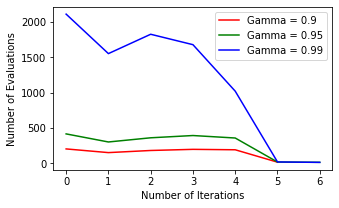

In [ ]:
gamma_vals = [0.9, 0.95, 0.99]
colors = ['r', 'g', 'b']
plt.figure(figsize=(5,3))
for i, gamma in enumerate(gamma_vals):
  env = StochasticEnv(MazeEnvCast5x5())
  pi = PolicyIteration(env, gamma=gamma)
  evals = pi.train()
  plt.plot(range(len(evals)), evals, colors[i], label='Gamma = {}'.format(gamma))
plt.xlabel('Number of Iterations')
plt.ylabel('Number of Evaluations')
plt.legend()
plt.show()

# print(f''' \nthe final policy:
# {pi.π}''')
# print(f'''\nthe final values:
# {pi.values}''')

### Solve 5x5 maze using PolicyIteration

In [ ]:
state = env.close()
env = StochasticEnv(MazeEnvCast5x5())
pi = PolicyIteration(env, gamma=gamma)
evals = pi.train()
state = env.reset()
start_time = time.time()
done = False
# iter = 0
video_filename = 'pi_5by5.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  # while (iter < 10) or not done:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 2:
      break
    # iter +=1
    action = pi.π[tuple(np.int32(state))]
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

  6%|▌         | 6/100 [00:02<00:32,  2.89it/s]
/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


# Model free algorithms:
Define 3 different algorithms:

• Monte Carlo

• Q-Learning

• SARSA

The goal is to run different Policies and of course solve in as few steps as possible.

###Monte Carlo



In [ ]:
class MonteCarlo():

  def __init__(self, env, num_episodes=500, num_steps=500, epsilon=0.99, decay=0.99, gamma=0.9, alpha=0.9):
    super().__init__()
    self.env = env
    self.num_episodes = num_episodes
    self.num_steps = num_steps
    self.epsilon = epsilon
    self.decay_rate = decay
    self.gamma = gamma
    self.alpha = alpha
    self.R = self.env.R
    self.Q = np.zeros((env.maze_size[0], env.maze_size[1], env.action_space.n))
    # number of visits for each state-action pair
    self.N = np.zeros((env.maze_size[0], env.maze_size[1], env.action_space.n))
    self.env.reset()

  def epsilon_greedy_policy(self, state):
    # Choose a random action with probability epsilon,
    # otherwise choose the action with the highest Q-value
    if np.random.rand() < self.epsilon:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.Q[state])

  def update_Q(self, states_actions_rewards):
    # Update Q-values using the Monte Carlo update rule
    G = 0
    for s, a, r in reversed(states_actions_rewards):
      G = r + G * self.gamma
      self.N[s[0]][s[1]][a] += 1
      self.Q[s[0]][s[1]][a] += self.alpha * (G - self.Q[s[0]][s[1]][a]) / self.N[s[0]][s[1]][a]

  def train(self):
    rewards = []
    for i in range(self.num_episodes):
      if i == self.num_episodes / 2:
        self.QhalfWay = self.Q.copy()
      self.epsilon = self.epsilon * self.decay_rate if self.epsilon * self.decay_rate > 0.05 else 0.05
      state = self.env.reset()
      if i % 20 != 0:
        state = self.env.set_random_state()
      states_actions_rewards = []
      done = False
      episode_reward = 0
      step = 0
      while not done and step < self.num_steps:
        # Choose an action according to the epsilon-greedy policy
        action = self.epsilon_greedy_policy(tuple(np.int32(state)))
        next_state, reward, done, _ = self.env.step(action)
        states_actions_rewards.append((tuple(np.int32(state)), action, reward))
        episode_reward += reward
        state = next_state.copy()
        step += 1
      self.update_Q(states_actions_rewards)
      if i % 20 == 0:
        # print(f"Episode {i}, total reward: {episode_reward}")
        rewards.append(episode_reward)
    return rewards

### Monte Carlo parameters exploration
Explore the best parameters to get the fastest convergence, we'll test each parameter separately and continue with the best to test the next one:

In [ ]:
def get_mean(lst_of_lst):
  averages = []
  for i in range(len(lst_of_lst[0])):
      total = 0
      for lst in lst_of_lst:
          total += lst[i]
      averages.append(total / len(lst_of_lst))
  return averages

First we'll test Gamma, the discount factor:

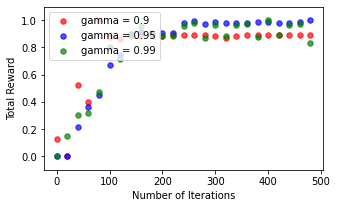

In [ ]:
gamma_vals = [0.9, 0.95, 0.99]
mean_vals = {gamma:[] for gamma in gamma_vals}

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  for gamma in gamma_vals:
    mc = MonteCarlo(env, gamma=gamma)
    mean_vals[gamma].append(mc.train())

colors = ['red', 'blue', 'green']
i = 0
plt.figure(figsize=(5,3))
for gamma in mean_vals.keys():
  rewards = get_mean(mean_vals[gamma])
  min_value = min(rewards)
  max_value = max(rewards)
  if min_value == max_value:
    normalized_rewards = [0] * len(rewards)
  else:
    normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
  x_coordinates = 20 * np.arange(len(rewards))
  plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='gamma = {}'.format(gamma))
  i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.show()

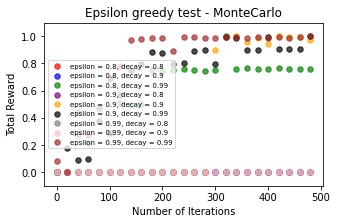

In [ ]:
eps_vals = [0.8, 0.9, 0.99]
decay_vals = [0.8, 0.9, 0.99]
mean_vals = {e: {d:[] for d in decay_vals} for e in eps_vals}
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'gray', 'pink', 'brown']
for i in range (25):
  env = StochasticEnv(MazeEnvCast15x15())
  for eps in eps_vals:
    for decay in decay_vals:
      mc = MonteCarlo(env, epsilon=eps, decay=decay)
      mean_vals[eps][decay].append(mc.train())
i = 0
plt.figure(figsize=(5,3))
for eps in mean_vals.keys():
  for decay in mean_vals[eps].keys():
    rewards = get_mean(mean_vals[eps][decay])
    min_value = min(rewards)
    max_value = max(rewards)
    if min_value == max_value:
      normalized_rewards = [0] * len(rewards)
    else:
      normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
    x_coordinates = 20 * np.arange(len(rewards))
    plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='epsilon = {}, decay = {}'.format(eps, decay))
    i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='center left', fontsize=7)
plt.title("Epsilon greedy test - MonteCarlo")
plt.show()

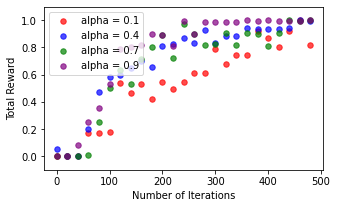

In [ ]:
alpha_vals = [0.1, 0.4, 0.7, 0.9]
mean_vals = {alpha:[] for alpha in alpha_vals}

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  for alpha in alpha_vals:
    mc = MonteCarlo(env, alpha=alpha)
    mean_vals[alpha].append(mc.train())

plt.figure(figsize=(5,3))
colors = ['red', 'blue', 'green', 'purple']
i = 0
for alpha in mean_vals.keys():
  rewards = get_mean(mean_vals[alpha])
  min_value = min(rewards)
  max_value = max(rewards)
  if min_value == max_value:
    normalized_rewards = [0] * len(rewards)
  else:
    normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
  x_coordinates = 20 * np.arange(len(rewards))
  plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='alpha = {}'.format(alpha))
  i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.show()

### Solve 15x15 maze using Monte Carlo
We'll train the model with the best parameters we found the best:

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
mc = MonteCarlo(env) # the default parameter are the best we found
_ = mc.train()

In the first video the decisions are based of the Q tabel half trained (after ~250 episodes) while in the Secod video the decision are based on the fully trained Q table (500 episodes):


In [ ]:
env.close()
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'mc_half_trained_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(mc.QhalfWay[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


In [ ]:
env.close()
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'mc_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(mc.Q[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

###Q-Learning

In [ ]:
class QLearning():

  def __init__(self, env, num_episodes=500, num_steps=500, epsilon=0.99, decay=0.99, gamma=0.99, alpha=0.9):
    super().__init__()
    self.env = env
    self.num_episodes = num_episodes
    self.num_steps = num_steps
    self.epsilon = epsilon
    self.decay_rate = decay
    self.gamma = gamma
    self.alpha = alpha
    self.Q = np.zeros((env.maze_size[0], env.maze_size[1], env.action_space.n))

  def select_act(self, state):
    # Choose a random action with probability epsilon,
    # otherwise choose the action with the highest Q-value
    if random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.Q[state])

  def update_Q(self, state, action, reward, next_state):
    self.Q[state][action] += self.alpha * (reward + self.gamma *
                                           max(self.Q[next_state]) - self.Q[state][action])

  def train(self):
    rewards = []
    for i in range(self.num_episodes):
      if i == self.num_episodes / 2:
        self.QhalfWay = self.Q.copy()
      self.epsilon = self.epsilon * self.decay_rate
      state = self.env.reset()
      done = False
      episode_reward = 0
      step = 0
      while not done and step < self.num_steps:
        # Choose an action according to the epsilon-greedy policy
        action = self.select_act(tuple(np.int32(state)))
        next_state, reward, done, _ = self.env.step(action)
        self.update_Q(tuple(np.int32(state)), action, reward, tuple(np.int32(next_state)))
        episode_reward += reward
        state = next_state.copy()
        step += 1
      if i % 20 == 0:
        rewards.append(episode_reward)
        # print(f"Episode {i}, total reward: {episode_reward}")
    return rewards

### Q-Learning parameters exploration
Explore the best parameters to get the fastest convergence, as we did in Monte Carlo:

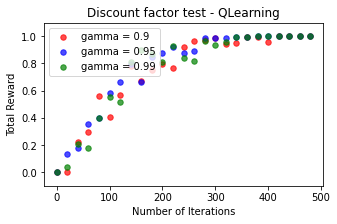

In [ ]:
gamma_vals = [0.9, 0.95, 0.99]
mean_vals = {gamma:[] for gamma in gamma_vals}

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  for gamma in gamma_vals:
    ql = QLearning(env, gamma=gamma)
    mean_vals[gamma].append(ql.train())

colors = ['red', 'blue', 'green']
i = 0
plt.figure(figsize=(5,3))
for gamma in mean_vals.keys():
  rewards = get_mean(mean_vals[gamma])
  min_value = min(rewards)
  max_value = max(rewards)
  if min_value == max_value:
    normalized_rewards = [0] * len(rewards)
  else:
    normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
  x_coordinates = 20 * np.arange(len(rewards))
  plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='gamma = {}'.format(gamma))
  i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='upper left')
plt.title("Discount factor test - QLearning")
plt.show()

<ipython-input-145-8d2b11fa9a1a>:29: MatplotlibDeprecationWarning: Unrecognized location 'centerer left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  plt.legend(loc='centerer left', prop={'size': 8})


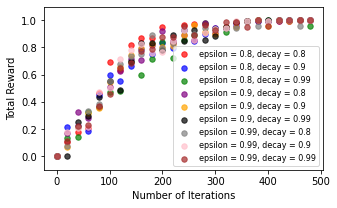

In [ ]:
eps_vals = [0.8, 0.9, 0.99]
decay_vals = [0.8, 0.9, 0.99]
mean_vals = {e: {d:[] for d in decay_vals} for e in eps_vals}
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'gray', 'pink', 'brown']
for i in range (25):
  env = StochasticEnv(MazeEnvCast15x15())
  for eps in eps_vals:
    for decay in decay_vals:
      ql = QLearning(env, epsilon=eps, decay=decay)
      mean_vals[eps][decay].append(ql.train())
i = 0
plt.figure(figsize=(5,3))
for eps in mean_vals.keys():
  for decay in mean_vals[eps].keys():
    rewards = get_mean(mean_vals[eps][decay])
    min_value = min(rewards)
    max_value = max(rewards)
    if min_value == max_value:
      normalized_rewards = [0] * len(rewards)
    else:
      normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
    x_coordinates = 20 * np.arange(len(rewards))
    plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='epsilon = {}, decay = {}'.format(eps, decay))
    i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='center left', prop={'size': 8})
plt.show()

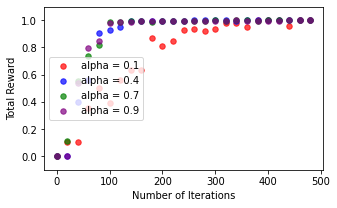

In [ ]:
alpha_vals = [0.1, 0.4, 0.7, 0.9]
mean_vals = {alpha:[] for alpha in alpha_vals}

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  for alpha in alpha_vals:
    ql = QLearning(env, alpha=alpha)
    mean_vals[alpha].append(ql.train())

plt.figure(figsize=(5,3))
colors = ['red', 'blue', 'green', 'purple']
i = 0
for alpha in mean_vals.keys():
  rewards = get_mean(mean_vals[alpha])
  min_value = min(rewards)
  max_value = max(rewards)
  if min_value == max_value:
    normalized_rewards = [0] * len(rewards)
  else:
    normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
  x_coordinates = 20 * np.arange(len(rewards))
  plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='alpha = {}'.format(alpha))
  i += 1
plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='center left')
plt.show()

### Solve 15x15 maze using Q-Learning:

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
ql = QLearning(env)
_ = ql.train()

In the first video the decisions are based of the Q tabel half trained (after ~250 episodes) while in the Secod video the decision are based on the fully trained Q table (500 episodes):


In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'ql_half_trained_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(ql.QhalfWay[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'ql_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(ql.Q[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


###SARSA

In [ ]:
class SARSA():

  def __init__(self, env, num_episodes=500, num_steps=500, epsilon=0.99, decay=0.99, gamma=0.99, alpha=0.9):
    super().__init__()
    self.env = env
    self.num_episodes = num_episodes
    self.num_steps = num_steps
    self.epsilon = epsilon
    self.decay_rate = decay
    self.gamma = gamma
    self.alpha = alpha
    self.Q = np.zeros((env.maze_size[0], env.maze_size[1], env.action_space.n))

  def select_act(self, state):
    # Choose a random action with probability epsilon,
    # otherwise choose the action with the highest Q-value
    if random.random() < self.epsilon:
      return self.env.action_space.sample()
    else:
      return np.argmax(self.Q[state])

  def update_Q(self, next_state, state, action, next_action, reward):
    self.Q[state][action] += self.alpha * (reward + self.gamma * self.Q[next_state][next_action] - self.Q[state][action])

  def train(self, episodes=500, max_steps=500):
    rewards = []
    for i in range(episodes):
      if i == self.num_episodes / 2:
        self.QhalfWay = self.Q.copy()
      self.epsilon *= self.decay_rate
      state = self.env.reset()
      done = False
      episode_reward = 0
      step = 0
      while not done and step < max_steps:
        # Choose an action according to the epsilon-greedy policy
        action = self.select_act(tuple(np.int32(state)))
        next_state, reward, done, _ = self.env.step(action)
        next_action = self.select_act(tuple(np.int32(next_state)))
        self.update_Q(tuple(np.int32(next_state)), tuple(np.int32(state)), action, next_action, reward)
        episode_reward += reward
        state = next_state.copy()
        step += 1
      if i % 20 == 0:
        rewards.append(episode_reward)
        # print(f"Episode {i}, total reward: {episode_reward}")
    return rewards

### Solve 15x15 omaze using SARSA:

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
sarsa = SARSA(env)
_ = sarsa.train()

In the first video the decisions are based of the Q tabel half trained (after ~250 episodes) while in the Secod video the decision are based on the fully trained Q table (500 episodes):

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'sarsa_half_trained_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(sarsa.QhalfWay[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

In [ ]:
env = StochasticEnv(MazeEnvCast15x15())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'sarsa_15by15.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(sarsa.Q[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


# Chnaging reward to better convergence:
Solve the 25x25 maze environment.
This task is to use a tool that will help create the "agent
encouragement" and set two Reward cells in strategic locations in the environment. The first reward will be a "positive reward" and the second reward will be a "negative reward" (punishment).

### fastest convergence
test which of the 3 model-free methods got the fastest convergence:

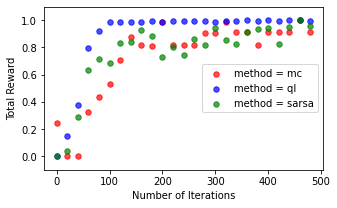

In [ ]:
methods = ['mc', 'ql', 'sarsa']
mean_vals = {method:[] for method in methods}

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  mc = MonteCarlo(env)
  mean_vals['mc'].append(mc.train())

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  ql = QLearning(env)
  mean_vals['ql'].append(ql.train())

for i in range(25):
  env = StochasticEnv(MazeEnvCast15x15())
  sarsa = SARSA(env)
  mean_vals['sarsa'].append(sarsa.train())

plt.figure(figsize=(5,3))
colors = ['red', 'blue', 'green']
i = 0
for m in mean_vals.keys():
  rewards = get_mean(mean_vals[m])
  min_value = min(rewards)
  max_value = max(rewards)
  if min_value == max_value:
    normalized_rewards = [0] * len(rewards)
  else:
    normalized_rewards = [(r - min_value) / (max_value - min_value) for r in rewards]
  x_coordinates = 20 * np.arange(len(rewards))
  plt.scatter(x_coordinates, normalized_rewards, c=colors[i], s=30, alpha=0.7,
            label='method = {}'.format(m))
  i += 1

plt.xlabel('Number of Iterations')
plt.ylabel('Total Reward')
plt.ylim(-0.1, 1.1)
plt.legend(loc='center right')
plt.show()

### Compare Model-free to model based over 25x25 maze:
Demonstrate the learning (free based) methode we found that has fastest convergence: QLearning, in comparison to model ased - Policy Iteration:

In [ ]:
env = StochasticEnv(MazeEnvCast25x25())
env.AddReward((2, 5), (23, 23))
pi = PolicyIteration(env, 100)
pi.train()

ql1 = QLearning(env)
_ = ql1.train()

 23%|██▎       | 23/100 [00:21<01:11,  1.07it/s]


In [ ]:
env = StochasticEnv(MazeEnvCast25x25())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'pi_25by25.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = pi.π[tuple(np.int32(state))]
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


In [ ]:
env = StochasticEnv(MazeEnvCast25x25())
state = env.reset()
start_time = time.time()
done = False
video_filename = 'ql1_25by25.mp4'
with imageio.get_writer(video_filename, fps=10) as video:
  while not done:
    time_passed = int(time.time() - start_time)
    if done or time_passed > 10:
      break
    action = np.argmax(ql1.Q[tuple(np.int32(state))])
    state, reward, done, info = env.step(action)
    video.append_data(env.render(mode='rgb_array'))
embed_mp4(video_filename)

/usr/local/lib/python3.8/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())
